In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/alzheimer/dataset.zip'
extract_path = '/content/datasett'  # Puedes cambiarlo si quieres extraerlo en otro lugar


In [4]:
# Verificar si hay GPU disponible
import tensorflow as tf
from tensorflow.python.client import device_lib

print("\n📟 Dispositivos disponibles:")
print(device_lib.list_local_devices())
print("\n🚀 TensorFlow detecta GPU:", tf.config.list_physical_devices('GPU'))



📟 Dispositivos disponibles:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11386982349919413626
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6311397466856335221
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]

🚀 TensorFlow detecta GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
# Activar Mixed Precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [11]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/alzheimer/dataset.zip'  # Ruta del archivo ZIP
extract_path = '/content/'  # Carpeta destino

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Archivo descomprimido en:", extract_path)


✅ Archivo descomprimido en: /content/


In [24]:
#Cargar el  del dataset
base_dir = '/content/dataset'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

In [25]:
#hiperparametros
input_shape = (224, 224, 3)
num_classes = 4
class_names = ['AD', 'CN', 'EMCI', 'LMCI']
batch_size = 32
epochs = 10

In [ ]:
# Modelo CNN dual

from tensorflow.keras import layers, Input, Model
from tensorflow.keras.optimizers import Adam

def build_combined_model_single_input(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNN 1
    x1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(128, activation='relu')(x1)

    # CNN 2
    x2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same')(x2)
    x2 = layers.Conv2D(128, (5, 5), activation='relu', padding='same')(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Conv2D(512, (5, 5), activation='relu', padding='same')(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.5)(x2)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(128, activation='relu')(x2)

    combined = layers.concatenate([x1, x2])
    output = layers.Dense(num_classes, activation='softmax', dtype='float32')(combined)

    return Model(inputs=inputs, outputs=output)

model = build_combined_model_single_input(input_shape, num_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ cast[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │      2,432 │ cast_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │     25,632 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      9,280 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │    102,528 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 112, 112,  │    409,728 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    147,712 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │  1,638,912 │ max_pooling2d_4[

 Total params: 79,450,612 (303.08 MB)

 Trainable params: 79,449,076 (303.07 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [26]:
#Generadores de datos

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 23244 images belonging to 4 classes.
Found 5812 images belonging to 4 classes.
Found 7264 images belonging to 4 classes.


In [ ]:
#Entrenamiento del modelo

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 1180s 470ms/step - accuracy: 0.5374 - loss: 1.4108 - val_accuracy: 0.8166 - val_loss: 0.4798
Epoch 2/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 129s 178ms/step - accuracy: 0.8541 - loss: 0.3633 - val_accuracy: 0.8782 - val_loss: 0.2988
Epoch 3/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 131s 180ms/step - accuracy: 0.9327 - loss: 0.1754 - val_accuracy: 0.8832 - val_loss: 0.3180
Epoch 4/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 129s 178ms/step - accuracy: 0.9646 - loss: 0.0940 - val_accuracy: 0.8909 - val_loss: 0.3475
Epoch 5/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 143s 179ms/step - accuracy: 0.9773 - loss: 0.0646 - val_accuracy: 0.9038 - val_loss: 0.3261
Epoch 6/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 130s 179ms/step - accuracy: 0.9852 - loss: 0.0425 - val_accuracy: 0.8821 - val_loss: 0.4370
Epoch 7/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 140s 177ms/step - accuracy: 0.9852 - loss: 0.0425 - val_accuracy: 0.8759 - val_loss: 0.5123
Epoch 8/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 129s 177ms/step - accuracy: 0.9871 

In [ ]:
#guardado del modelo
model.save("dual_cnn_model.h5")
print("\n✅ Modelo guardado como 'dual_cnn_model.h5'")


✅ Modelo guardado como 'dual_cnn_model.h5'


In [27]:
#Evaluación y visualización

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [30]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo
model = load_model("dual_cnn_model.h5")
# Predicciones
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Accuracy en el conjunto de prueba: {accuracy:.4f}")

# Reporte de clasificación
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


OSError: Unable to synchronously open file (truncated file: eof = 199229440, sblock->base_addr = 0, stored_eof = 953527088)

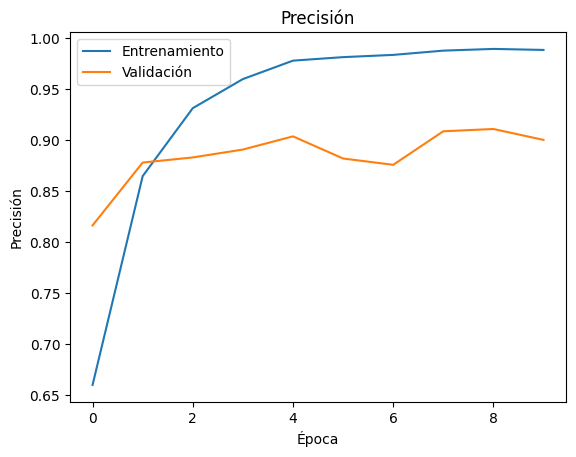

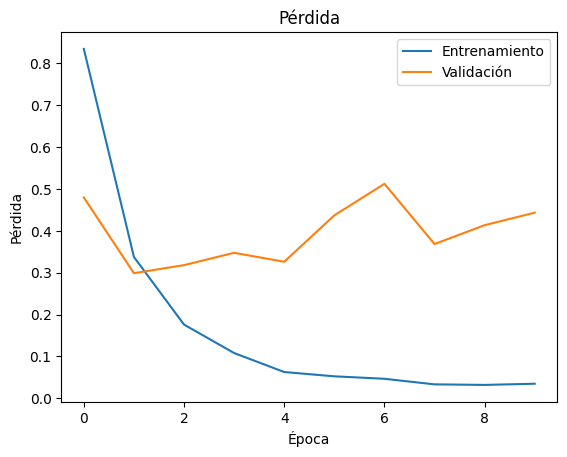

In [ ]:
# Curvas de entrenamiento
plt.figure()
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validaci\u00f3n')
plt.title('Precisi\u00f3n')
plt.xlabel('\u00c9poca')
plt.ylabel('Precisi\u00f3n')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validaci\u00f3n')
plt.title('P\u00e9rdida')
plt.xlabel('\u00c9poca')
plt.ylabel('P\u00e9rdida')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


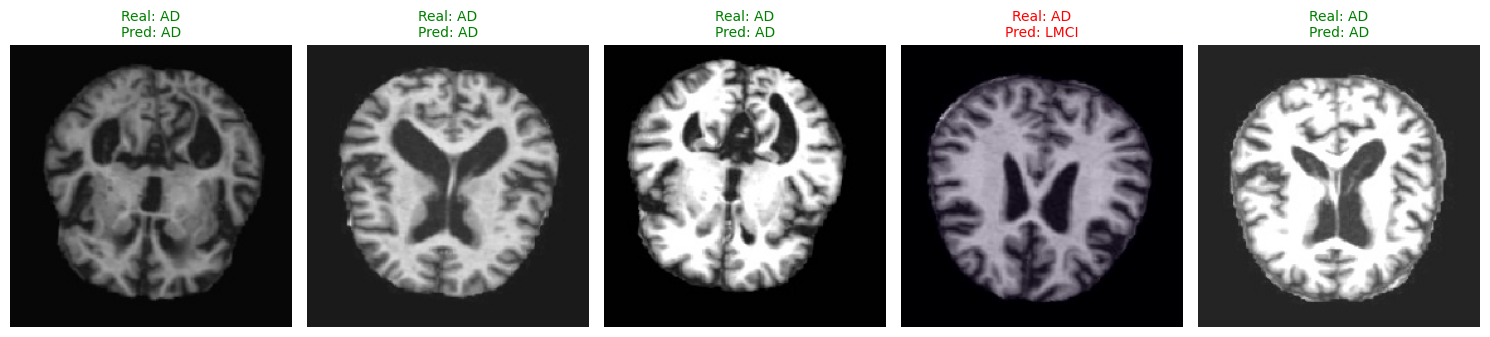

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Visualización mejorada de predicciones con imágenes variadas
plt.figure(figsize=(15, 6))

for i in range(5):
    # Tomar un batch aleatorio del generador
    img_batch, label_batch = next(test_gen)

    # Seleccionar una imagen aleatoria dentro del batch
    idx = random.randint(0, len(img_batch) - 1)
    img = np.expand_dims(img_batch[idx], axis=0)
    label = label_batch[idx]

    # Hacer la predicción
    pred = model.predict(img)
    pred_class = class_names[np.argmax(pred)]
    true_class = class_names[np.argmax(label)]
    is_correct = pred_class == true_class

    # Mostrar la imagen
    plt.subplot(1, 5, i + 1)
    plt.imshow(img[0])
    plt.title(f"Real: {true_class}\nPred: {pred_class}",
              color='green' if is_correct else 'red', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
